In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import seaborn as sns
from os import listdir, mkdir
from os.path import isfile, join, exists
import time

%matplotlib inline

In [2]:
def gauss_compress_step(img):
    return cv.GaussianBlur(img, (5,5), 0)[::2, ::2, :].clip(0, 255).astype(np.uint8)

In [3]:
def compress_image(img):
    return gauss_compress_step(gauss_compress_step(img))

In [4]:
def show_image(img):
    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.show()

In [5]:
def compress_all_jpg_in_directory(path):
    onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]
    result_path = path + "_compress"
    if not exists(result_path):
        mkdir(result_path)
        
    for num, filename in enumerate(onlyfiles):
        img = cv.imread(path + "/" + filename)
        name = "pict_" + str(num) + ".png"
        compress_img = compress_image(img)
        cv.imwrite(result_path + "/" + name, compress_img)   

In [6]:
def draw_matches(img_first, img_second, callable_descriptor):
    keypoints_first, descriptors_first = callable_descriptor(img_first)
    keypoints_second, descriptors_second = callable_descriptor(img_second)
    draw_matches_tech(img_first, keypoints_first, descriptors_first,
                      img_second, keypoints_second, descriptors_second)

In [7]:
def draw_matches_tech(img_first, keypoints_first, descriptor_first, 
                 img_second, keypoints_second, descriptor_second):
    bf = cv.BFMatcher(cv.NORM_L2, crossCheck=True)

    matches = bf.match(descriptor_first, descriptor_second)
    matches = sorted(matches, key = lambda x:x.distance)    
    img3 = cv.drawMatches(img_first, keypoints_first, img_second, keypoints_second, matches[:], img_second, flags=2)
    plt.imshow(img3)
    plt.show()

In [8]:
def match_accuracy(matches, count_all_features):
    first_set_idx = [matches[i].trainIdx for i in range(len(matches))]
    second_set_idx = [matches[i].queryIdx for i in range(len(matches))]
    first_set_count_features = len(set(first_set_idx))
    second_set_count_features = len(set(second_set_idx))
    
    return (first_set_count_features + second_set_count_features) / count_all_features    

In [9]:
def match_mean_distance(matches):
    return np.mean([matches[i].distance for i in range(len(matches))])

In [10]:
def calc_SIFT(img):
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    sift = cv.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(img, None)
    
    return keypoints, descriptors

In [11]:
def calc_AKAZE(img):
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    sift = cv.AKAZE_create()
    keypoints, descriptors = sift.detectAndCompute(img, None)
    
    return keypoints, descriptors

In [12]:
def calc_BRISK(img):
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    sift = cv.BRISK_create()
    keypoints, descriptors = sift.detectAndCompute(img, None)
    
    return keypoints, descriptors

In [13]:
def calc_process_images(origin_image, list_of_images, callback_descriptor, descriptor_name):
    origin_keypoints, origin_descriptors = callback_descriptor(origin_image)
    result_metrics = []
    if descriptor_name in ['SIFT', 'AKAZE']:
        bf = cv.BFMatcher(cv.NORM_L2, crossCheck=True)
    elif descriptor_name == 'BRISK':
        bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
    for current_image in list_of_images:
        start_time = time.time()
        
        current_keypoints, current_descriptors = callback_descriptor(current_image[0])
        matches = bf.match(origin_descriptors, current_descriptors)
        
        curr_time = time.time() - start_time
        
        accury = match_accuracy(matches, len(origin_keypoints) + len(current_keypoints))
        mean_distance = match_mean_distance(matches)
        result_metrics.append((accury, mean_distance, curr_time, current_image[0]))
    
    return result_metrics

In [14]:
def prepare_data(path, need_compress=False):
    if need_compress:
        compress_all_jpg_in_directory(path)
        path = path + "_compress"
        
    
    list_of_images = []
    images = [f for f in listdir(path) if isfile(join(path, f))]
    for im in images:
        current_image = cv.imread(path + "/" + im)
        list_of_images.append((current_image, im))
    
    return list_of_images

In [15]:
def main_process(descriptor_name, path_to_folder_with_images, path_to_origin_image, need_to_compress):
    #ну тут нужно харкодить))
    name_to_desc = {'SIFT': calc_SIFT, 'AKAZE': calc_AKAZE, 'BRISK': calc_BRISK}
    origin_image = cv.imread(path_to_origin_image)
    
    return calc_process_images(origin_image, prepare_data(path_to_folder_with_images, need_to_compress),
                               name_to_desc[descriptor_name], descriptor_name)

In [16]:
def draw_results(metrics_result, descriptor_name, origin_image):
    n = len(metrics_result)
    
    plt.figure(figsize=(16, 6))
    
    plt.subplot(1, 3, 1)
    y = [metrics_result[i][0] for i in range(n)]
    plt.plot(np.arange(len(y)), y)
    plt.title('match accuracy')
    plt.xlabel('number of sample')
    plt.ylabel('accuracy')
    
    plt.subplot(1, 3, 2)
    y = [metrics_result[i][1] for i in range(n)]
    plt.plot(np.arange(len(y)), y)
    plt.title('mean distance')
    plt.xlabel('number of sample')
    plt.ylabel('distance')
    
    plt.subplot(1, 3, 3)
    y = [metrics_result[i][2] for i in range(n)]
    plt.plot(np.arange(len(y)), y)
    plt.title('time')
    plt.xlabel('number of sample')
    plt.ylabel('time')
    
    plt.show()

Рассмотрим первый датасет, будем искать следующий предмет:

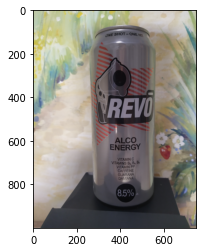

In [17]:
image = cv.imread('dataset1/original_picture.png')
plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
plt.show()

Для поиска данного предмета среди картинок датасета, мы сгенерируем для него дескриптор (с помощью SIFT, BRISK и AKAZE), аналогично сгенерируем дескриптор для картинки, на которой мы хотим найти этот объект, и дальнейшее решение будем принимать по метрикам, которые мы измерим при сравнении дескрипторов.

Найдем этот предмет в датасете, используя SIFT и отобразим полученные результаты:

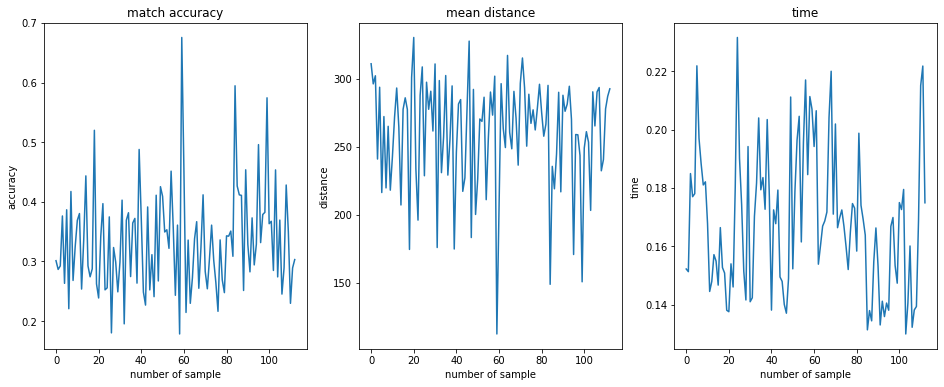

In [18]:
result_metrics = main_process('SIFT', 'dataset1/dataset1_compress', 'dataset1/original_picture.png', False)
draw_results(result_metrics, 'SIFT', None)

Отсортируем результаты по точности

In [19]:
result_metrics = sorted(result_metrics, key = lambda x:x[0])

И теперь построим совпадения исходной картинки с картинкой, на которой достигается максимальная / минимальная точность и возьмем картинку со средним результатом.

Минимальная точность:

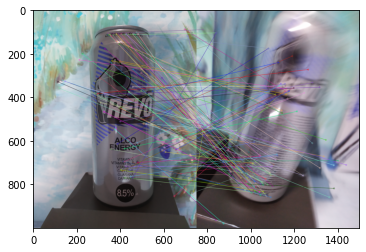

In [20]:
draw_matches(image, result_metrics[0][3], calc_SIFT)

Максимальная точность:

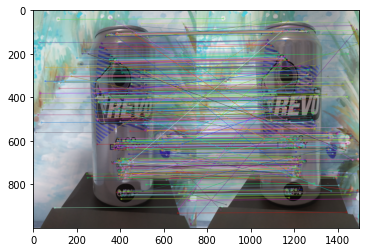

In [21]:
draw_matches(image, result_metrics[-1][3], calc_SIFT)

Вариант посередине:

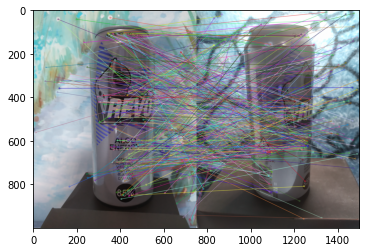

In [22]:
draw_matches(image, result_metrics[len(result_metrics) // 2][3], calc_SIFT)

Теперь проведем аналогичные действия для AKAZE

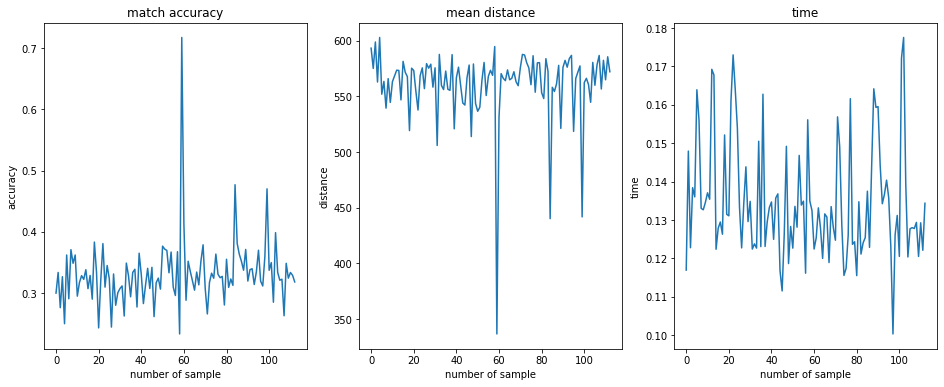

In [23]:
result_metrics = main_process('AKAZE', 'dataset1/dataset1_compress', 'dataset1/original_picture.png', False)
draw_results(result_metrics, 'AKAZE', None)

Отсортируем результаты по точности

In [24]:
result_metrics = sorted(result_metrics, key = lambda x:x[0])

Минимальная точность:

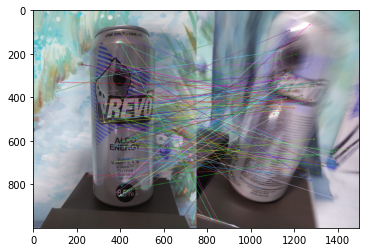

In [25]:
draw_matches(image, result_metrics[0][3], calc_AKAZE)

Максимальная точность:

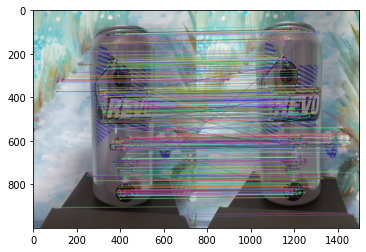

In [26]:
draw_matches(image, result_metrics[-1][3], calc_AKAZE)

Вариант посередине:

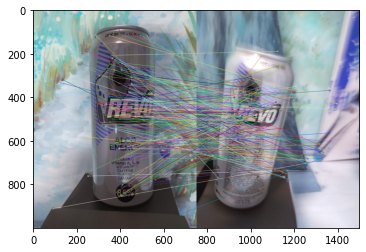

In [27]:
draw_matches(image, result_metrics[len(result_metrics) // 2][3], calc_AKAZE)

И теперь для BRISK

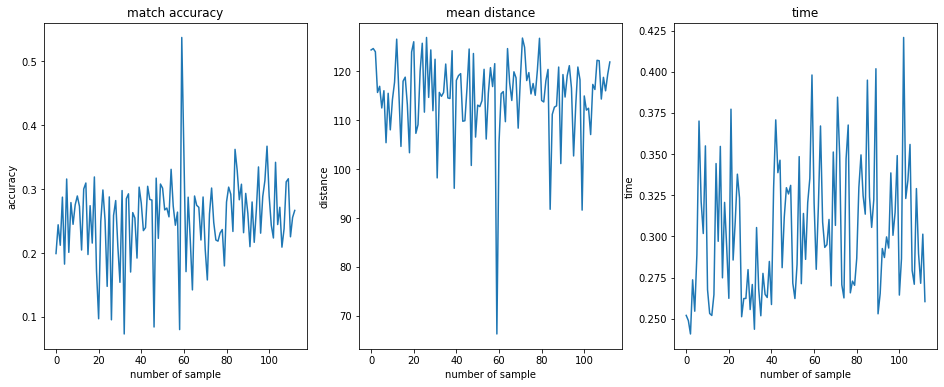

In [28]:
result_metrics = main_process('BRISK', 'dataset1/dataset1_compress', 'dataset1/original_picture.png', False)
draw_results(result_metrics, 'BRISK', None)

Отсортируем результаты по точности

In [29]:
result_metrics = sorted(result_metrics, key = lambda x:x[0])

Минимальная точность:

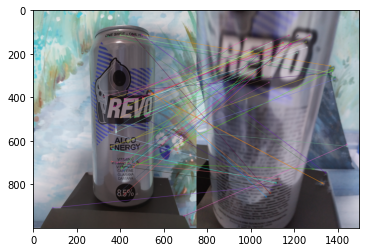

In [30]:
draw_matches(image, result_metrics[0][3], calc_BRISK)

Максимальная точность:

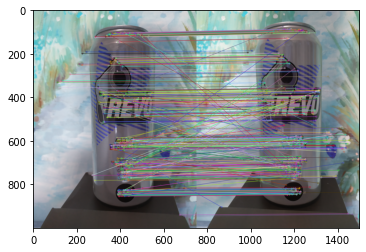

In [31]:
draw_matches(image, result_metrics[-1][3], calc_BRISK)

Вариант посередине:

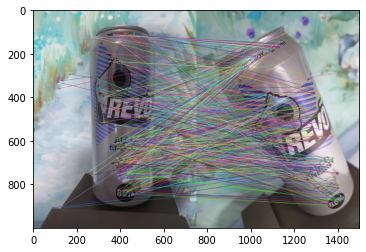

In [32]:
draw_matches(image, result_metrics[len(result_metrics) // 2][3], calc_BRISK)

Теперь перейдем к следующему датасету, будем искать вот эту вещь:

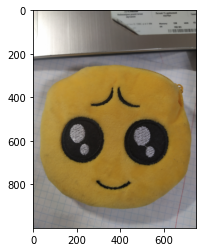

In [33]:
image = cv.imread('dataset2/original_picture.png')
plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
plt.show()

Дальше проделаем действия, аналогичные тем, что мы делали выше

Дескриптор SIFT

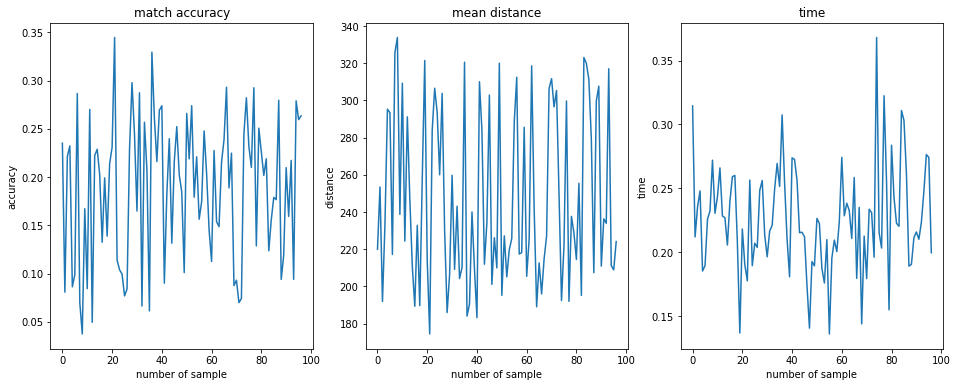

In [34]:
result_metrics = main_process('SIFT', 'dataset2/dataset2_compress', 'dataset2/original_picture.png', False)
draw_results(result_metrics, 'SIFT', None)

Отсортируем результаты по точности

In [35]:
result_metrics = sorted(result_metrics, key = lambda x:x[0])

Минимальная точность:

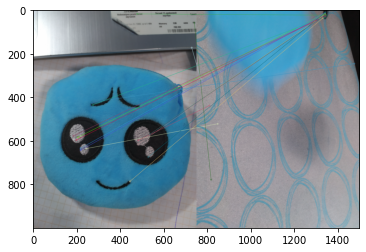

In [36]:
draw_matches(image, result_metrics[0][3], calc_SIFT)

Максимальная точность:

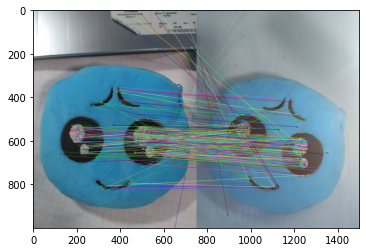

In [37]:
draw_matches(image, result_metrics[-1][3], calc_SIFT)

Вариант посередине:

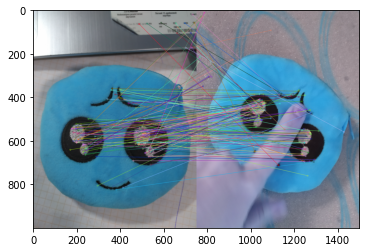

In [38]:
draw_matches(image, result_metrics[len(result_metrics) // 2][3], calc_SIFT)

Дескриптор AKAZE

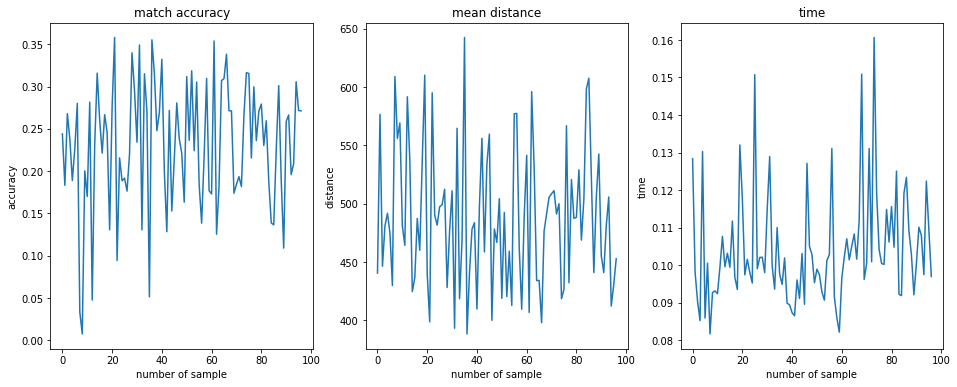

In [39]:
result_metrics = main_process('AKAZE', 'dataset2/dataset2_compress', 'dataset2/original_picture.png', False)
draw_results(result_metrics, 'AKAZE', None)

Отсортируем результаты по точности

In [40]:
result_metrics = sorted(result_metrics, key = lambda x:x[0])

Минимальная точность:

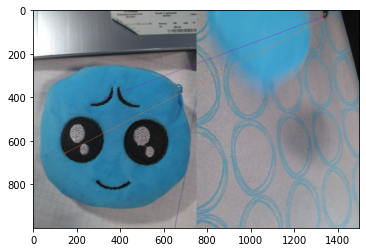

In [41]:
draw_matches(image, result_metrics[0][3], calc_AKAZE)

Максимальная точность:

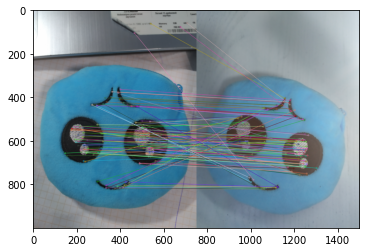

In [42]:
draw_matches(image, result_metrics[-1][3], calc_AKAZE)

Вариант посередине:

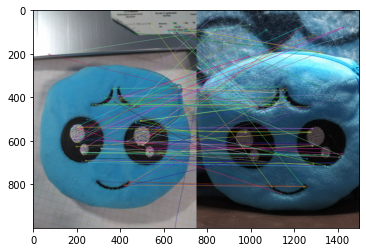

In [43]:
draw_matches(image, result_metrics[len(result_metrics) // 2][3], calc_AKAZE)

Дескриптор BRISK

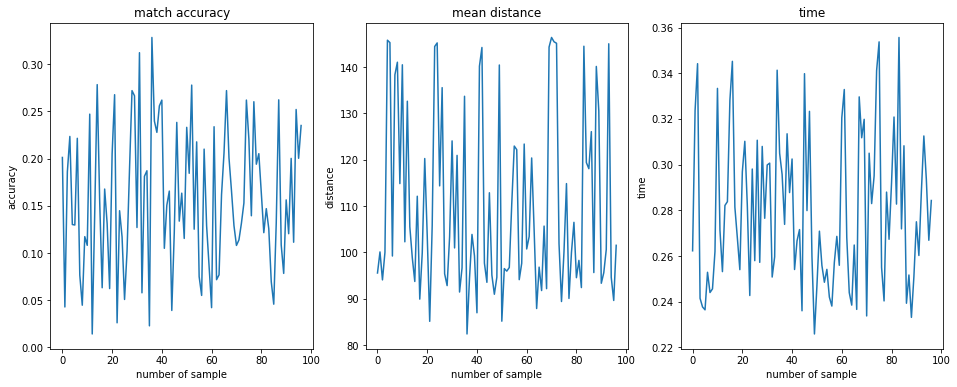

In [44]:
result_metrics = main_process('BRISK', 'dataset2/dataset2_compress', 'dataset2/original_picture.png', False)
draw_results(result_metrics, 'BRISK', None)

Отсортируем результаты по точности

In [45]:
result_metrics = sorted(result_metrics, key = lambda x:x[0])

Минимальная точность:

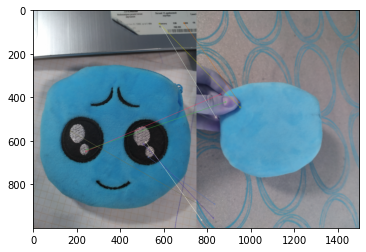

In [46]:
draw_matches(image, result_metrics[0][3], calc_BRISK)

Максимальная точность:

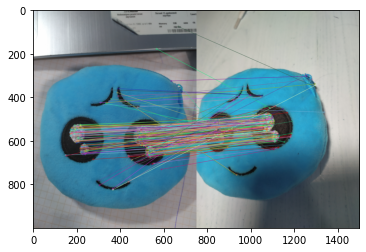

In [47]:
draw_matches(image, result_metrics[-1][3], calc_BRISK)

Вариант посередине (:

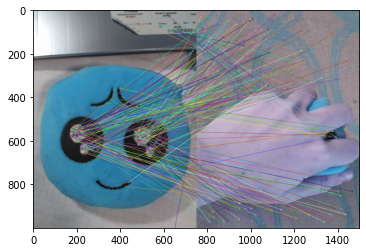

In [48]:
draw_matches(image, result_metrics[len(result_metrics) // 2][3], calc_BRISK)

И последний датасет, будем распознавать следующий образ

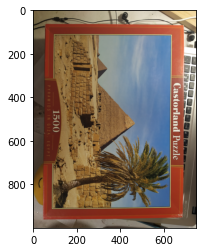

In [49]:
image = cv.imread('dataset3/original_picture.png')
plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
plt.show()

Дескриптор SIFT

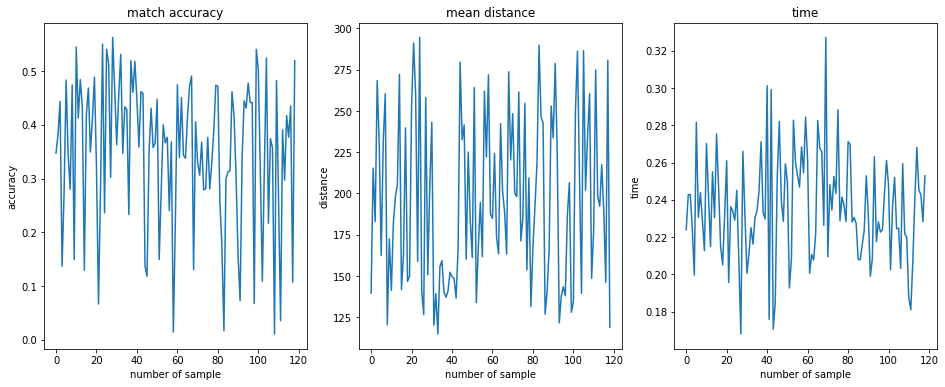

In [50]:
result_metrics = main_process('SIFT', 'dataset3/dataset3_compress', 'dataset3/original_picture.png', False)
draw_results(result_metrics, 'SIFT', None)

Отсортируем результаты по точности

In [51]:
result_metrics = sorted(result_metrics, key = lambda x:x[0])

Минимальная точность:

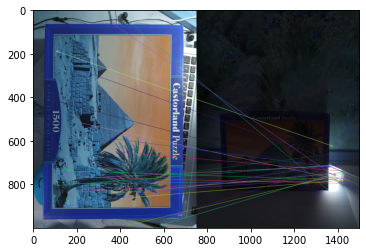

In [52]:
draw_matches(image, result_metrics[0][3], calc_SIFT)

Максимальная точность:

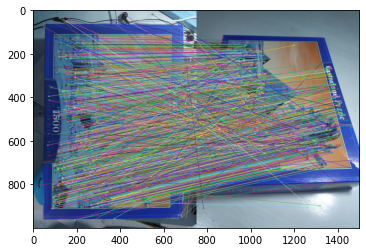

In [53]:
draw_matches(image, result_metrics[-1][3], calc_SIFT)

Вариант посередине:

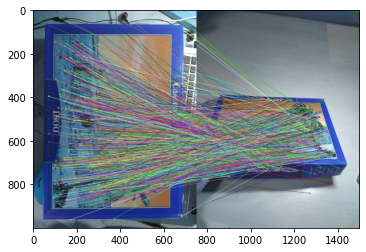

In [54]:
draw_matches(image, result_metrics[len(result_metrics) // 2][3], calc_SIFT)

Дескриптор AKAZE

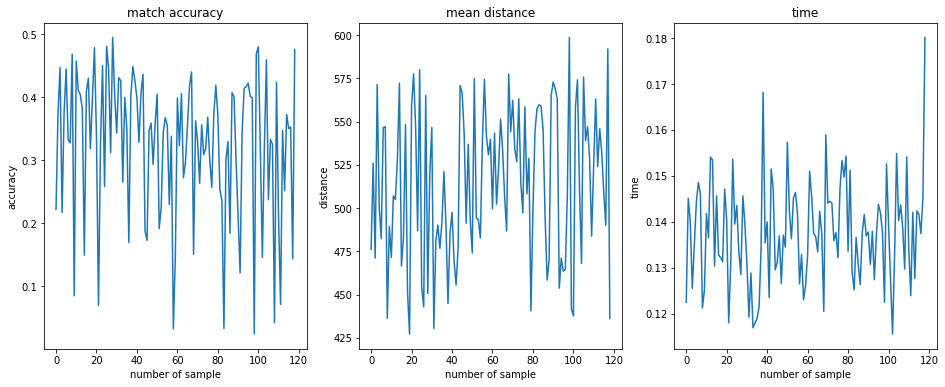

In [55]:
result_metrics = main_process('AKAZE', 'dataset3/dataset3_compress', 'dataset3/original_picture.png', False)
draw_results(result_metrics, 'AKAZE', None)

Отсортируем результаты по точности

In [56]:
result_metrics = sorted(result_metrics, key = lambda x:x[0])

Минимальная точность:

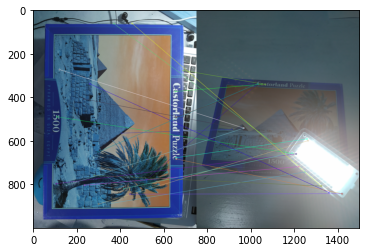

In [57]:
draw_matches(image, result_metrics[0][3], calc_AKAZE)

Максимальная точность:

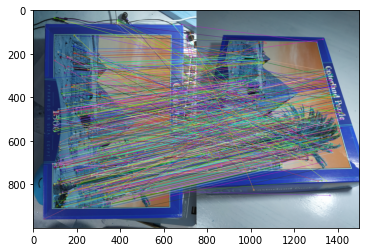

In [58]:
draw_matches(image, result_metrics[-1][3], calc_AKAZE)

Вариант посередине:

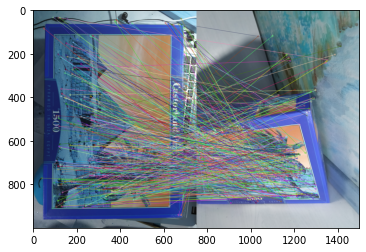

In [59]:
draw_matches(image, result_metrics[len(result_metrics) // 2][3], calc_AKAZE)

Дескриптор BRISK

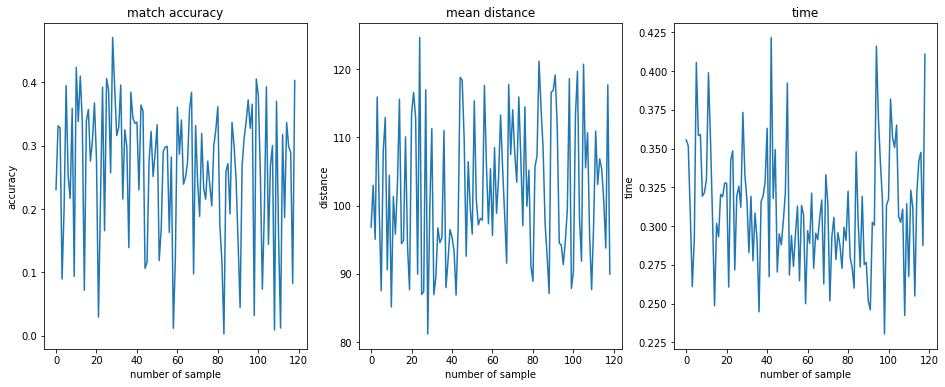

In [60]:
result_metrics = main_process('BRISK', 'dataset3/dataset3_compress', 'dataset3/original_picture.png', False)
draw_results(result_metrics, 'BRISK', None)

Отсортируем результаты по точности

In [61]:
result_metrics = sorted(result_metrics, key = lambda x:x[0])

Минимальная точность:

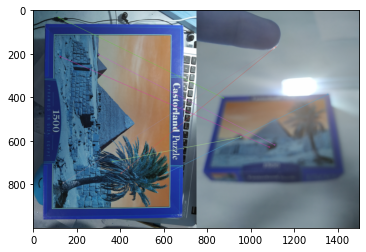

In [62]:
draw_matches(image, result_metrics[0][3], calc_BRISK)

Максимальная точность:

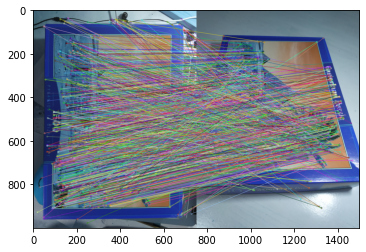

In [63]:
draw_matches(image, result_metrics[-1][3], calc_BRISK)

Вариант посередине:

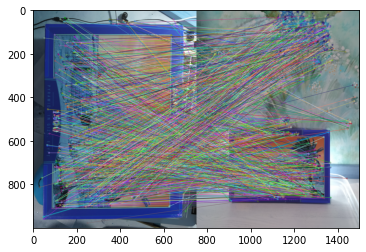

In [64]:
draw_matches(image, result_metrics[len(result_metrics) // 2][3], calc_BRISK)

Ура, конец!

   Рассмотрим по порядку нами сгенерированное: 
    В зависимости от датасета, примерно 5-10 процента точек на графике находится ниже значения 0.10, что соответсвует отсутвию
предмета на картинке, возможны ложноположительные обнаружения благодаря общему фону на картинках, где предмет есть, и на картинках, где его нет
    На каждом графике match accuracy для каждого дескриптора имеется несколько пиков: мы вправе утверждать, что они соответствуют картинкам, на которых вещь изображена в анфас, как и на исходном изображении